# SUPERVISED LEARNING - CLASSIFICATION PROJECT

- PROJECT: Supervised Learning - Classification
* Multiple class problem. Use `OneVsRestClassifier`.
* Is your dataset balanced?
         - What is the balance between classes?
* Train 2 different models
* Give metrics (de los dos modelos)
        - Accuracy or Balanced Accuracy Score (if your dataset is not balanced)

- Precision
- Recall
- F1Score
- ROC Curve 
- AUC
- Confussion Matrix (not normalized)

In [1]:
# importamos las librerias necesarias:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Abrimos el dataset que hemos descargado de Kaggle; lista de videojuegos con ventas mayores de 100,000 copias.

Incluye los siguientes campos:

-Rank - Ranking of overall sales
-Name - The games name
-Platform - Platform of the games release (i.e. PC,PS4, etc.)
-Year - Year of the game's release
-Genre - Genre of the game
-Publisher - Publisher of the game
-NA_Sales - Sales in North America (in millions)
-EU_Sales - Sales in Europe (in millions)
-JP_Sales - Sales in Japan (in millions)
-Other_Sales - Sales in the rest of the world (in millions)
-Global_Sales - Total worldwide sales.

In [2]:
df = pd.read_csv("../vgsales.csv")
print(df.shape)
df.head()

(16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Analizamos el dataset:

In [3]:
df.dtypes

Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

Mostramos los valores de las columnas Genre, Platform, y Publisher:

In [4]:
df.Genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [5]:
df.Publisher.value_counts()

Electronic Arts                           1351
Activision                                 975
Namco Bandai Games                         932
Ubisoft                                    921
Konami Digital Entertainment               832
THQ                                        715
Nintendo                                   703
Sony Computer Entertainment                683
Sega                                       639
Take-Two Interactive                       413
Capcom                                     381
Atari                                      363
Tecmo Koei                                 338
Square Enix                                233
Warner Bros. Interactive Entertainment     232
Disney Interactive Studios                 218
Unknown                                    203
Midway Games                               198
Eidos Interactive                          198
505 Games                                  192
Microsoft Game Studios                     189
D3Publisher  

El feature Publisher tiene demasiados valores como para que sea relevante; nos quedamos con las 16 mas importantes, y el resto las agrupamos en "other":

In [6]:
def publisher(x, publishers=['Electronic Arts', 'Activision', 'Namco Bandai Games', 'Ubisoft', 'Konami Digital Entertainment', 'THQ', 'Nintendo','Sony Computer Entertainment', 'Sega', 'Take-Two Interactive', 'Capcom','Atari', 'Tecmo Koei','Square Enix', 'Warner Bros. Interactive Entertainment','Disney Interactive Studios']):
    if x in publishers:
        return x
    else:
        return 'Other'
    
df.Publisher = df.Publisher.apply(lambda x: publisher(x))
df.Publisher.value_counts()

Other                                     6669
Electronic Arts                           1351
Activision                                 975
Namco Bandai Games                         932
Ubisoft                                    921
Konami Digital Entertainment               832
THQ                                        715
Nintendo                                   703
Sony Computer Entertainment                683
Sega                                       639
Take-Two Interactive                       413
Capcom                                     381
Atari                                      363
Tecmo Koei                                 338
Square Enix                                233
Warner Bros. Interactive Entertainment     232
Disney Interactive Studios                 218
Name: Publisher, dtype: int64

In [7]:
df.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Buscamos los valores nulos:

In [8]:
df.isnull().sum(axis = 0)

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher         0
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

Imprimimos el heatmap para ver a correlacion entre las features; 

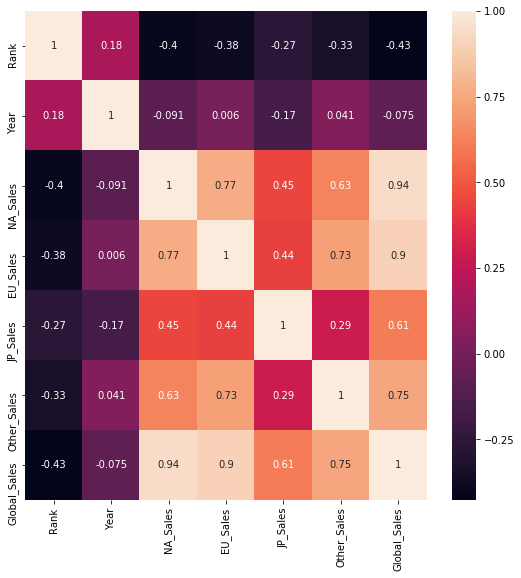

In [10]:
fig, ax = plt.subplots(figsize=(9,9)) 
sb.heatmap(df.corr(), annot=True, ax=ax)

Eliminamos:
 - la columna Name, porque no nos aporta informacion relevante:
 - la columna Rank, porque esta directamente relacionada con Global Sales.
 - Global_Sales y NA_Sales tiene una alta correlacion; por eso eliminamos la segunda
 - y las filas con valores nulos:

In [11]:
df_drop = df.drop(columns=["Rank", "Name", "NA_Sales"], axis=1).dropna()
df_drop.head()

,Platform,Year,Genre,Publisher,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii,2006.0,Sports,Nintendo,29.02,3.77,8.46,82.74
1,NES,1985.0,Platform,Nintendo,3.58,6.81,0.77,40.24
2,Wii,2008.0,Racing,Nintendo,12.88,3.79,3.31,35.82
3,Wii,2009.0,Sports,Nintendo,11.01,3.28,2.96,33.00
4,GB,1996.0,Role-Playing,Nintendo,8.89,10.22,1.00,31.37


Aplicamos One Hot Encoding, haciendo un get_dummies con las columnas 'Platform' y 'Publisher', y definimos X e y:

In [12]:
# Dataset ready to train
X_nodummies = df[['Platform', 'Publisher']]

display(df.Genre.value_counts())

X = pd.get_dummies(data=X_nodummies,drop_first=True)
y = pd.get_dummies(data=df['Genre'])
display(X.head(),y.head())
print(X.shape)

Action          3316
Sports          2346
Misc            1739
Role-Playing    1488
Shooter         1310
Adventure       1286
Racing          1249
Platform         886
Simulation       867
Fighting         848
Strategy         681
Puzzle           582
Name: Genre, dtype: int64

,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,Platform_N64,...,Publisher_Nintendo,Publisher_Other,Publisher_Sega,Publisher_Sony Computer Entertainment,Publisher_Square Enix,Publisher_THQ,Publisher_Take-Two Interactive,Publisher_Tecmo Koei,Publisher_Ubisoft,Publisher_Warner Bros. Interactive Entertainment
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0


(16598, 46)


In [ ]:
#1er intento:
    #Creamos la X (datos) y la y (etiqueta): y será "Genre", que es valor que queremos predecir, y X, el resto de columnas: 

#df_with_dummies = pd.get_dummies(df_drop, columns=['Platform', 'Publisher'], drop_first=True)
#df_with_dummies.head()cols = [col for col in df_with_dummies.columns.values if col != "Genre"]

#X = df_with_dummies[cols]
#y = df_with_dummies[['Genre']]

#display(X.head(),y.head())

Creamos los clasificadores, y hacemos el cross-validation:
    - KNeighbors
    - Ramdom Forest

In [13]:
cls_kn = KNeighborsClassifier(n_neighbors=3)

scores1 = cross_val_score(cls_kn, X, y, cv=5)
print(scores1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

[0.14548193 0.16415663 0.13012048 0.1156975  0.09370292]
Accuracy: 0.13 (+/- 0.05)


In [15]:
cls_forest = OneVsRestClassifier(RandomForestClassifier(n_estimators=20))

scores2 = cross_val_score(cls_forest, X, y, cv=5)
print(scores2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

[0.07018072 0.06987952 0.04518072 0.03645676 0.02139199]
Accuracy: 0.05 (+/- 0.04)


Dividimos X e y en train/test con numpy:

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(13278, 46) (3320, 46) (13278, 12) (3320, 12)


## KNeighbors:

Entrenamos el primer clasificador (KNeighbors), y hacemos la predicción:

In [17]:
#fit:
cls_kn.fit(X_train, y_train)

#predict:
#print(y_test - cls_kn.predict(X_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

Calculamos los valores actuales y las predicciones; y en base a eso, los balanced_accuracy_score y accuracy_score: 

In [19]:
from sklearn.metrics import confusion_matrix

actual_values = y_test.values.argmax(axis=1)
predictions = cls_kn.predict(X_test).argmax(axis=1)
print(actual_values)

cm = confusion_matrix(actual_values, predictions)

[ 6  0 11 ...  1 11 10]


In [20]:
from sklearn.metrics import balanced_accuracy_score

print(balanced_accuracy_score(actual_values, predictions))

from sklearn.metrics import accuracy_score

print(accuracy_score(actual_values, predictions))

0.12022212315476427
0.21746987951807228


Construimos la matriz de confusion(no-normalizada):

Confusion matrix, without normalization
[[504  19   6  28  10   1   5  12  28   1  50   1]
 [190  24   1  11   1   0   2  12   6   3   9   1]
 [127   6   8   3   0   0   1   9   3   0   9   1]
 [254   9   3  14   1   1   1   8   3  11  25   0]
 [144   6   3  11   3   2   0   4   7   1   5   0]
 [ 91   0   2   5   1   0   0   1   0   5   3   0]
 [202   1   1   9   4   1   2   9   2   1  27   0]
 [210  13   8   4   0   0   1  36   2   2   6   1]
 [188   4   5   4   0   3   3  11  26   0  19   0]
 [128   7   1   8   1   0   1   5   6   9   5   0]
 [325  18   1  11   1   1   2  11  12   3  96   0]
 [109   0   4   2   0   0   3  16   4   2   7   0]]


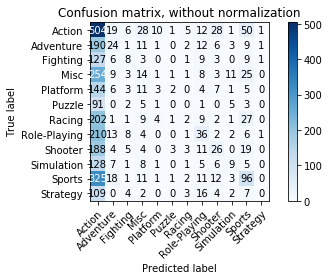

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

Calculamos los datos de precision, recall y F1:

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(actual_values, predictions, average='micro')
recall = recall_score(actual_values, predictions, average='micro')
f1_score = f1_score(actual_values, predictions, average='micro')

In [45]:
print(precision)

0.21746987951807228


In [46]:
print(recall)

0.21746987951807228


In [47]:
print(f1_score)

0.21746987951807228


In [ ]:
# Calcular la ROC curve de los dos cls:
def plotMetricsCompare(X, y, cls1, cls2):
    y_pred_proba = cls1.predict_proba(X)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    
    y_pred_proba1 = cls2.predict_proba(X)[::,1]
    fpr1, tpr1, _ = metrics.roc_curve(y,  y_pred_proba1)
    auc1 = metrics.roc_auc_score(y, y_pred_proba1)

    plt.title("AUC Model 1: {:2f} AUC Model 2: {:2f}".format(auc, auc1))
    plt.plot(fpr,tpr)
    plt.plot(fpr1,tpr1)
    plt.legend(["Model 1", "Model 2"])

plotMetricsCompare(X,y,cls,cls_svm)